# Ref
[word2vecでitem2vecを実装して映画を推薦する](https://ohke.hateblo.jp/entry/2017/12/08/230000)

In [19]:
# Import
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from gensim.models import word2vec

# Global
ML_25M_PATH = pathlib.Path("../ml-25m/")
PREPROCESSED_PATH = pathlib.Path("../preprocessed/")

In [30]:
# Preprocess
file_name = "ratings.csv"
ratings = pd.read_csv(ML_25M_PATH / file_name)
ratings = ratings.rename(columns={"userId": "user_id", "movieId": "item_id"}).drop(
    "timestamp", axis=1
)
ratings["rating"] = ratings["rating"].astype(int)

s = ratings["user_id"].unique()
sample_user = np.random.randint(s.min(), s.max(), 1000)
ratings = ratings[ratings["user_id"].isin(sample_user)]

file_name = "movies.csv"
movies = pd.read_csv(ML_25M_PATH / file_name)
movies = movies.rename(columns={"title": "item_title", "movieId": "item_id"}).drop(
    "genres", axis=1
)
movies["item_id"] = movies["item_id"].astype(int)

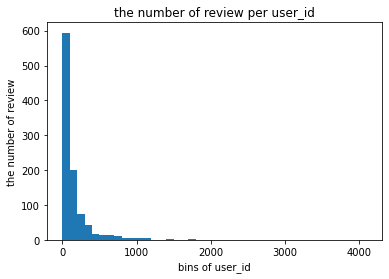

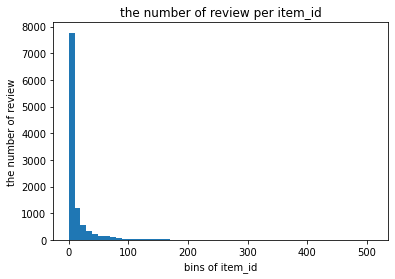

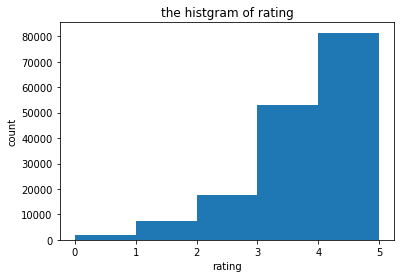

In [31]:
# Visualize
## function
def histgram(subject: str, step: int) -> None:
    """Create histgram"""
    fig = plt.figure()
    ax = fig.add_subplot(111)

    s = ratings.groupby(subject).count()["rating"].sort_values(ascending=False)

    min_ = 0
    max_ = s.max()

    ax.hist(s, bins=range(min_, max_ + step, step))
    ax.set_title(f"the number of review per {subject}")
    ax.set_ylabel(f"the number of review")
    ax.set_xlabel(f"bins of {subject}")
    plt.show()


## the number of review per user_id
histgram("user_id", 100)

## the number of review per item_id
histgram("item_id", 10)

## the histgram of ratings
fig = plt.figure()
ax = fig.add_subplot(111)
min_ = ratings["rating"].min()
max_ = ratings["rating"].max()
step = 1
ax.hist(ratings["rating"], bins=range(min_, max_ + step, step))
ax.set_title(f"the histgram of rating")
ax.set_ylabel("count")
ax.set_xlabel("rating")
plt.show()

In [32]:
# Preprocess
user_like_dict = {}

for user_id in tqdm.tqdm(ratings["user_id"].unique()):
    # ユーザーごとに、評価が平均値以上のアイテムIDを抽出して、" "で連結する
    average = np.average(ratings[ratings["user_id"] == user_id]["rating"])
    user_ratings = ratings[
        (ratings["user_id"] == user_id) & (ratings["rating"] >= average)
    ]
    user_like_dict[user_id] = " ".join(user_ratings["item_id"].astype("str"))

user = min(user_like_dict.keys())
print(f"user[{user}]: {user_like_dict[user]}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 1441.74it/s]

user[489]: 110 260 296 318 356 527 858 1092 1196 1203 1210 1221 1527 1682 2028 2288 2329 2628 2762 2858 3578 4223 4226 4874 4995 5989 5995 6016 6323 7143 7254 7458 8644 33493 33794 34048 40732 44191 44555 47610 48774 48780 55282 55908 56145 56174 57368 58559 62644 63072 64614 64983 68157 70286 74228 74458 81562 81788 83450 89774 91529 92259 93988 96829 97866 99145 101864 103249 104374 104841 104879 105504 106782 107406 109487 111362 111759 112556 113741 113829 114935 115713 115969 116897 122882 122886 134130 139385 140174 140956 141890 143355 143657 145064 152017 152077 157318 160980 161634 162082 163645 164179 166534 167832 168608 169906 170705 170745 172017 175569 176751 184257 185029 185475 187611 189885 192385 193477 194074


In [33]:
# Output
## user_like_dict.txtファイルに書き出す。
with open(PREPROCESSED_PATH / "user_like_dict.txt", "w") as f:
    f.write("\n".join(user_like_dict.values()))

In [34]:
# Modeling
sentences = word2vec.LineSentence(PREPROCESSED_PATH / "user_like_dict.txt")

# word2vecのモデルを構築
#     sg: 1ならskip-gram(cbowではなく)
#     size: 単語ベクトルの次元数
#     window: ウィンドウサイズ(今回は1行に含まれる全ての単語を対象とするため大きな値を設定)
#     hs: 0ならネガティブサンプリング(1なら階層的ソフトマックス)
#     negative: ネガティブサンプリングする単語数(結果への影響が予測できなかったのでデフォルトの5に設定)
#     seed: 乱数シード(結果を安定させたいので固定値を設定)
model = word2vec.Word2Vec(
    sentences, sg=1, vector_size=300, window=100000, hs=0, negative=5, seed=0
)

In [62]:
## Evaluation
def print_similar_titles(tuples):
    print(tuples)
    for t in tuples:
        print(f"{t[0]} : {movies.loc[int(t[0]), 'item_title']} : {t[1]}")


eval_id = pd.merge(ratings, movies, how="inner", on="item_id")["item_id"].unique()[:3]
for id_ in eval_id:
    print(id_, ":", movies[movies["item_id"] == id_]["item_title"].iloc[0])
    print_similar_titles(model.wv.most_similar(positive=id_, topn=5))

16 : Casino (1995)
[('5952', 0.8397096991539001), ('33794', 0.7916227579116821), ('6539', 0.7810099720954895), ('6874', 0.7629263401031494), ('5445', 0.759172260761261)]
5952 : Harder They Fall, The (1956) : 0.8397096991539001
33794 : Little Dorrit (2008) : 0.7916227579116821
6539 : Pink Panther, The (1963) : 0.7810099720954895
6874 : Housesitter (1992) : 0.7629263401031494
5445 : Stakeout (1987) : 0.759172260761261
47 : Seven (a.k.a. Se7en) (1995)
[('1270', 0.8281213045120239), ('1197', 0.8271593451499939), ('1704', 0.8109044432640076), ('1682', 0.8084269762039185), ('1136', 0.8074641227722168)]
1270 : Butch Cassidy and the Sundance Kid (1969) : 0.8281213045120239
1197 : Raging Bull (1980) : 0.8271593451499939
1704 : Further Gesture, A (1996) : 0.8109044432640076
1682 : Half Baked (1998) : 0.8084269762039185
1136 : 2 ou 3 choses que je sais d'elle (2 or 3 Things I Know About Her) (1967) : 0.8074641227722168
50 : Usual Suspects, The (1995)
[('32', 0.8075454831123352), ('47', 0.78331035